In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models

In [3]:
plt.style.use('../paper/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches

In [4]:
lgMh_s0_mat = np.load("../../../data/MW-analog/meta_data_psi3/models.npz")["mass"]

lgMh_s15_mat = np.load("../../../data/cross_host/lognorm_015_psi3/models.npz")["mass"]

lgMh_s30_mat = np.load("../../../data/cross_host/lognorm_030_psi3/models.npz")["mass"]

In [5]:
def correlation_hists(theta, min_mass, savefile=None):

    lgMs_s0_mat = np.apply_along_axis(jsm_SHMR.general_old, 0, theta, lgMh_s0_mat, 0, 1)
    lgMs_s15_mat = np.apply_along_axis(jsm_SHMR.general_old, 0, theta, lgMh_s15_mat, 0, 1)
    lgMs_s30_mat = np.apply_along_axis(jsm_SHMR.general_old, 0, theta, lgMh_s30_mat, 0, 1)
    Rp_s0 = []
    Rp_s15 = []
    Rp_s30 = []

    for i in range(lgMs_s0_mat.shape[0]):
        Rp_s0.append(jsm_stats.SatStats_D(lgMs_s0_mat[i], min_mass=min_mass, max_N=500).correlation)
        Rp_s15.append(jsm_stats.SatStats_D(lgMs_s15_mat[i], min_mass=min_mass, max_N=500).correlation)
        Rp_s30.append(jsm_stats.SatStats_D(lgMs_s30_mat[i], min_mass=min_mass, max_N=500).correlation)

    bins = np.linspace(-0.2, 1, 25)
    counts_s0, bincenters = jsm_stats.count(Rp_s0, bins, return_bins=True)
    counts_s15 = jsm_stats.count(Rp_s15, bins, return_bins=False)
    counts_s30 = jsm_stats.count(Rp_s30, bins, return_bins=False)

    plt.figure(figsize=(single_textwidth, single_textwidth))
    plt.hist(Rp_s0, bins, edgecolor="white", alpha=0.4, color="green", label="$S_0$")
    plt.step(bincenters, counts_s0, where="mid", color="green")
    plt.axvline(np.average(Rp_s0), color="green", ls='--')

    plt.hist(Rp_s15, bins, edgecolor="white", alpha=0.4, color="darkorange", label="$S_{15}$")
    plt.step(bincenters, counts_s15, where="mid", color="darkorange")
    plt.axvline(np.average(Rp_s15), color="darkorange", ls='--')

    plt.hist(Rp_s30, bins, edgecolor="white", alpha=0.4, color="red", label="$S_{30}$")
    plt.step(bincenters, counts_s30, where="mid", color="red")
    plt.axvline(np.average(Rp_s30), color="red", ls='--')

    plt.ylim(0.05)
    plt.axvline(0, color="grey", ls="--")
    plt.text(-0.1, 10, s="Uncorrelated", rotation="vertical", fontsize=12)
    plt.xlabel("Pearson R")
    plt.ylabel("frequency")
    plt.legend(framealpha=1)

    if savefile != None:
        plt.tight_layout()
        plt.savefig(savefile, bbox_inches="tight")

    else:
        plt.show()

    return Rp_s0

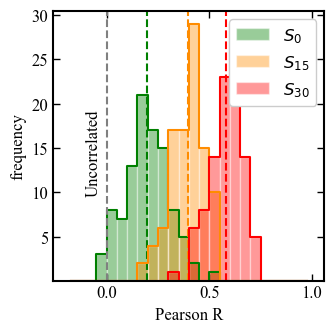

In [6]:
original = correlation_hists([10.5, 2.0, 0.2, 0, 0, 0], 6.5, savefile=None)

In [7]:
# alphas = np.linspace(1.5, 3.5, 5)

# sigmas = np.linspace(0.1, 0.5, 5)

In [8]:
# for alpha in alphas:
#     correlation_hists([10.5, alpha, 0.2, 0, 0, 0], 6.5)

In [9]:
# host_s0 = np.load("../../../data/MW-analog/meta_data_psi3/host_properties.npy")

# host_s15 = np.load("../../../data/cross_host/lognorm_015_psi3/host_properties.npy")

# host_s30 = np.load("../../../data/cross_host/lognorm_030_psi3/host_properties.npy")

In [10]:
# redbins = np.linspace(0,4,20)
# plt.hist(host_s0[:,1], bins=redbins, edgecolor="white", color="green")
# plt.hist(host_s15[:,1], bins=redbins, edgecolor="white", color="orange")
# plt.hist(host_s30[:,1], bins=redbins, edgecolor="white", color="red")
# plt.xlabel("z50")
# plt.show()

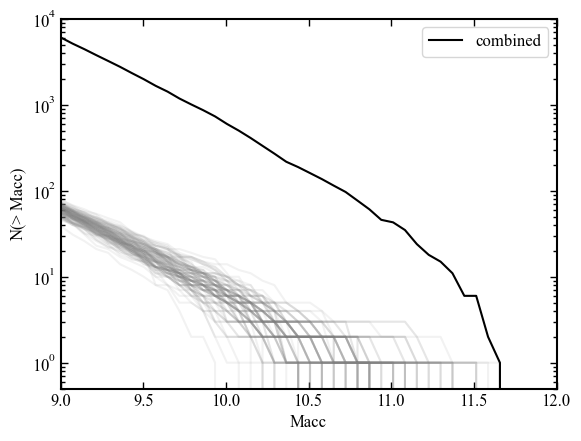

In [17]:
submass_bins = np.linspace(9.0,11.8,40)
plot = True

SHMFs = np.apply_along_axis(jsm_stats.cumulative, 1, lgMh_s0_mat[32], mass_bins=submass_bins)
hmm = lgMh_s0_mat[32].flatten()
combined = hmm[~np.isnan(hmm)]

combined_SHMF = jsm_stats.cumulative(combined, mass_bins=submass_bins)

if plot==True:
    for host_i in SHMFs:
        plt.plot(submass_bins[0:-1], host_i, alpha=0.1, color="grey")
    plt.plot(submass_bins[0:-1], combined_SHMF, color="black", label="combined")
    plt.yscale("log")
    plt.ylim(0.5, 1e4)
    plt.xlim(9,12)
    plt.xlabel("Macc")
    plt.ylabel("N(> Macc)")
    plt.legend()
    plt.show()

saga_Ms = jsm_SHMR.general_old([10.5, 2.0, 0.2, 0, 0, 0], lgMh_s0_mat[99], 0, 1)
instance = jsm_stats.SatStats_D(saga_Ms, min_mass=6.5, max_N=500)

rp_vdb_test = []
for i in range(100):
    mstar_maxes = []
    for Nsat in instance.Nsat_perhost:
        rand_draw = np.random.randint(low=0, high=combined.shape[0], size=Nsat)
        rand_Macc = combined[rand_draw]
        rand_Mstar = jsm_SHMR.general_old([10.5, 2.0, 0.2, 0, 0, 0], rand_Macc, 0, 1)
        mstar_maxes.append(rand_Mstar.max())

    rp_vdb_test.append(jsm_stats.correlation(instance.Nsat_perhost, np.array(mstar_maxes)))

In [18]:
bins = np.linspace(-0.2, 1, 25)
counts_s0, bincenters = jsm_stats.count(original, bins, return_bins=True)

counts_test = jsm_stats.count(rp_vdb_test, bins, return_bins=False)

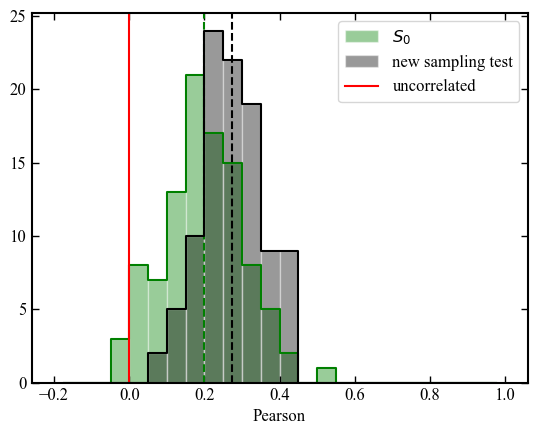

In [19]:
plt.hist(original, bins, edgecolor="white", alpha=0.4, color="green", label="$S_0$")
plt.step(bincenters, counts_s0, where="mid", color="green")
plt.axvline(np.average(original), color="green", ls='--')

plt.hist(rp_vdb_test, bins, edgecolor="white", alpha=0.4, color="k", label="new sampling test")
plt.step(bincenters, counts_test, where="mid", color="k")
plt.axvline(np.average(rp_vdb_test), color="k", ls='--')

plt.axvline(0, color="red", label="uncorrelated")
plt.legend()
plt.xlabel("Pearson")
plt.show()